---
title: Image reconstruction using Random Fourier Features vs Rank Decomposition
author: ["Guntas Singh Saran", "Hrriday V. Ruparel"]
date: "2024-03-06"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Image Processing"]

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.image import imsave
from latex import latexify, format_axes
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
def save_reconstructed_image(outputs, save_path):
  outputs = outputs.cpu().numpy().clip(0, 1)
  outputs = (outputs * 255).astype(np.uint8)
  pil_image = Image.fromarray(outputs)
  pil_image.save(save_path)

In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


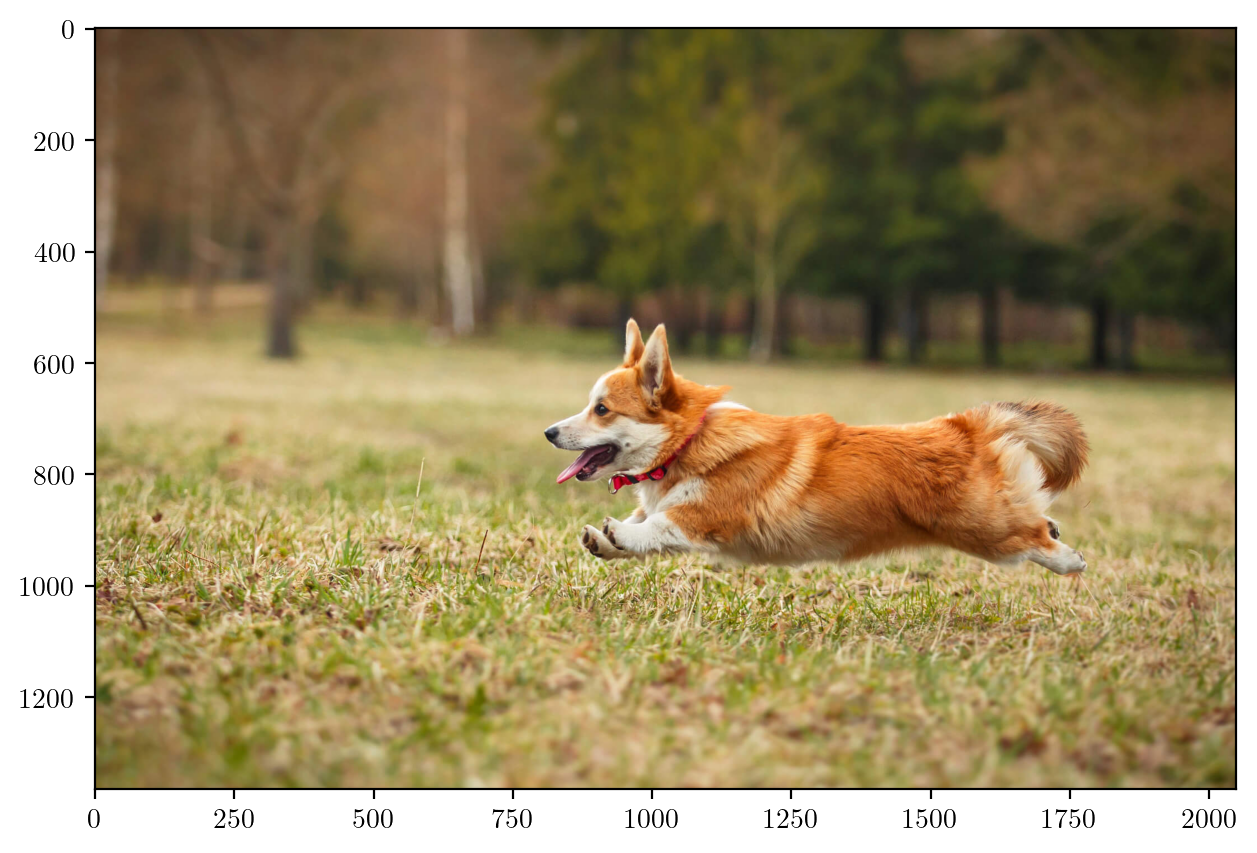

In [4]:
latexify(columns = 2, fig_width = 8)
plt.imshow(rearrange(img, "c h w -> h w c").numpy())
plt.show()

In [5]:
img = transforms.functional.crop(img.cpu(), 600, 800, 300, 300)
print(img.shape)

torch.Size([3, 300, 300])


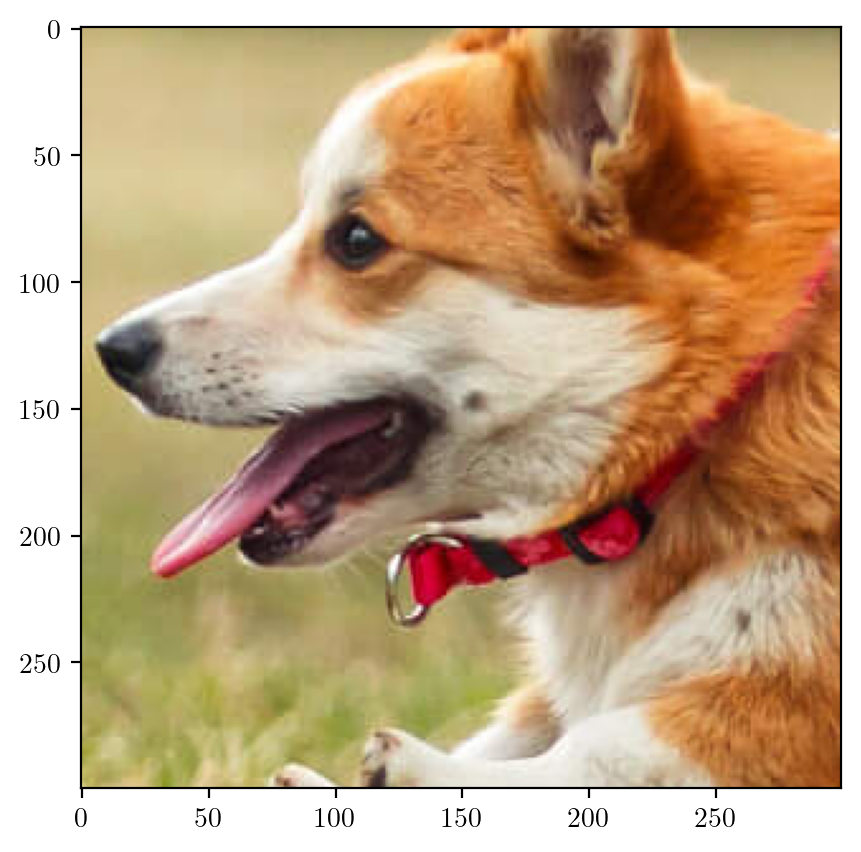

In [6]:
latexify(columns = 2, fig_width = 8)
plt.imshow(rearrange(img, "c h w -> h w c").numpy())
plt.show()

In [7]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device, dtype = torch.float32)
img_scaled

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

### Function for removing Patch

In [8]:
def remove_patch(img, Corner, d, display = True):
    X, Y = Corner
    latexify(columns = 2, fig_width = 10)
    img_copy = img.clone()
    img_copy[:, X : X + d, Y : Y + d] = float("nan")
    crop = transforms.functional.crop(img.cpu(), X, Y, d, d)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [img.shape[2] / (5 * d), 1]})
    fig.suptitle(fr"Patch size = $({d} \times {d})$ removed", fontsize = 16)
    ax[0].imshow(rearrange(img_copy, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title("Masked Image")
    ax[1].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title("Masked Crop")
    if (display):
        plt.show()
    else:
        plt.close()
    return img_copy, crop

### Function for removing Subset

In [9]:
def remove_subset(img, d, display = True):
    latexify(columns = 2, fig_width = 8)
    img_copy = img.clone()
    height, width = img.shape[1], img.shape[2]
    random_h_coords = random.sample(range(height), d)
    random_w_coords = random.sample(range(width), d)
    img_copy[:, random_h_coords, random_w_coords] = float("nan")
    plt.title(fr"Random {d*d} points removed from image", fontsize = 16)
    plt.imshow(rearrange(img_copy, 'c h w -> h w c').cpu().numpy())
    if (display):
        plt.show()
    else:
        plt.close()
    return img_copy

#### $$ \text{PSNR} = 20 \log_{10}(\frac{\text{MAX}_I}{\sqrt{\text{MSE}}})$$

In [10]:
def metrics(img1, img2, max_value = 1.0):
  rmse = torch.sqrt(F.mse_loss(img1, img2))
  psnr_value = 20 * torch.log10(max_value / rmse)
  return rmse, psnr_value.item()

## Gradient Descent using Adam Optimizer $A_{N \times M} \approx W_{N \times k} H_{k \times M}$

In [13]:
def factorize(Img, k, convergence, device = torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    Img = Img.to(device)
    losses, images = [], []
    for channel in range(Img.shape[0]):
        A = Img[channel]

        torch.manual_seed(42)
        W = torch.randn(A.shape[0], k, requires_grad = True, device = device)
        H = torch.randn(k, A.shape[1], requires_grad = True, device = device)

        optimizer = optim.Adam([W, H], lr = 0.02)
        mask = ~torch.isnan(A)
        prev_loss = float('inf')
        for i in range(10000):

            diff_matrix = torch.mm(W, H) - A
            diff_vector = diff_matrix[mask]
            loss = torch.norm(diff_vector)

            if torch.abs(prev_loss - loss) < convergence:
                break

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            prev_loss = loss.item()

        losses.append(loss)
        images.append(torch.mm(W, H))

    return losses, torch.stack([images[0], images[1], images[2]], dim = 0), i

## Function for Training and Plotting the Reconstructed Image

In [14]:
def train_reconstruct_plot_patch(img, Corner, d, features, convergence, device, allowSave = False, FileName = None, allowMetrics = False):
  imgSingle, croppedSingle = remove_patch(img, Corner, d, display = False)
  losses, FinalImage, i = factorize(imgSingle, features, convergence, device)
  img_copy = FinalImage.clone()
  X, Y = Corner
  newCroppedSingle = img_copy[:, X : X + d, Y : Y + d]
  rmse, psnr = metrics(img, img_copy)
  latexify(columns = 2)
  fig, ax = plt.subplots(nrows = 1, ncols = 3, gridspec_kw = {"width_ratios": [img.shape[2] / (3 * d), 1, img.shape[2] / (3 * d)]}, figsize = (15, 8))
  fig.suptitle(f"RMSE : {rmse} | PNSR : {psnr}" "\n" fr"Crop Corner = $({X}, {Y})$" "\n" f"Features = {features}" "\n" fr"Loss Red = {losses[0]}, Loss Green = {losses[0]}, Loss Blue = {losses[2]}" "\n" f"Converged after {i} iteration", fontsize = 12)
  ax[0].imshow(rearrange(imgSingle, 'c h w -> h w c').cpu().numpy())
  ax[0].set_title("Masked Image" "\n" rf"$({img.shape[1]} \times {img.shape[2]})$")
  ax[1].imshow(rearrange(croppedSingle, 'c h w -> h w c').cpu().numpy())
  ax[1].set_title("Patch" "\n" fr"$({d} \times {d})$")
  ax[2].imshow(rearrange(FinalImage, 'c h w -> h w c').cpu().detach().numpy())
  ax[2].set_title("Reconstructed Image" "\n" rf"$({img.shape[1]} \times {img.shape[2]})$")
  if (allowSave):
      save_reconstructed_image(rearrange(FinalImage, 'c h w -> h w c').detach(), FileName)
  for i in range(3):
      ax[i].axis("off")
  plt.show()

  fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [1, 1]}, figsize = (8, 4))
  fig.suptitle("Comparison of Original and Reconstructed Patch", fontsize = 12)
  ax[0].imshow(rearrange(croppedSingle, 'c h w -> h w c').cpu().numpy())
  ax[0].set_title("Original Patch")
  ax[0].axis("off")
  ax[1].imshow(rearrange(newCroppedSingle, 'c h w -> h w c').cpu().detach().numpy())
  ax[1].set_title("Reconstructed Patch")
  ax[1].axis("off")
  plt.show()

  if (allowMetrics):
      return rmse, psnr

In [15]:
def train_reconstruct_plot_subset(img, d, features, convergence, device, allowSave = False, FileName = None, allowMetrics = False):
  imgSingle = remove_subset(img, d, display = False)
  losses, FinalImage, i = factorize(imgSingle, features, convergence, device)
  img_copy = FinalImage.clone()
  rmse, psnr = metrics(img, img_copy)
  latexify(columns = 2)
  fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [1, 1]}, figsize = (10, 6))
  fig.suptitle(f"RMSE : {rmse} | PNSR : {psnr}" "\n" f"Features = {features}" "\n" fr"Loss Red = {losses[0]}, Loss Green = {losses[0]}, Loss Blue = {losses[2]}" "\n" f"Converged after {i} iteration", fontsize = 12)
  ax[0].imshow(rearrange(imgSingle, 'c h w -> h w c').cpu().numpy())
  ax[0].set_title("Masked Image")
  ax[0].axis("off")
  ax[1].imshow(rearrange(FinalImage, 'c h w -> h w c').cpu().detach().numpy())
  ax[1].set_title("Reconstructed Image")
  ax[1].axis("off")
  if (allowSave):
      save_reconstructed_image(rearrange(FinalImage, 'c h w -> h w c').detach(), FileName)
  plt.show()

  if (allowMetrics):
      return rmse, psnr

### $(30 \times 30)$ Patch Missing

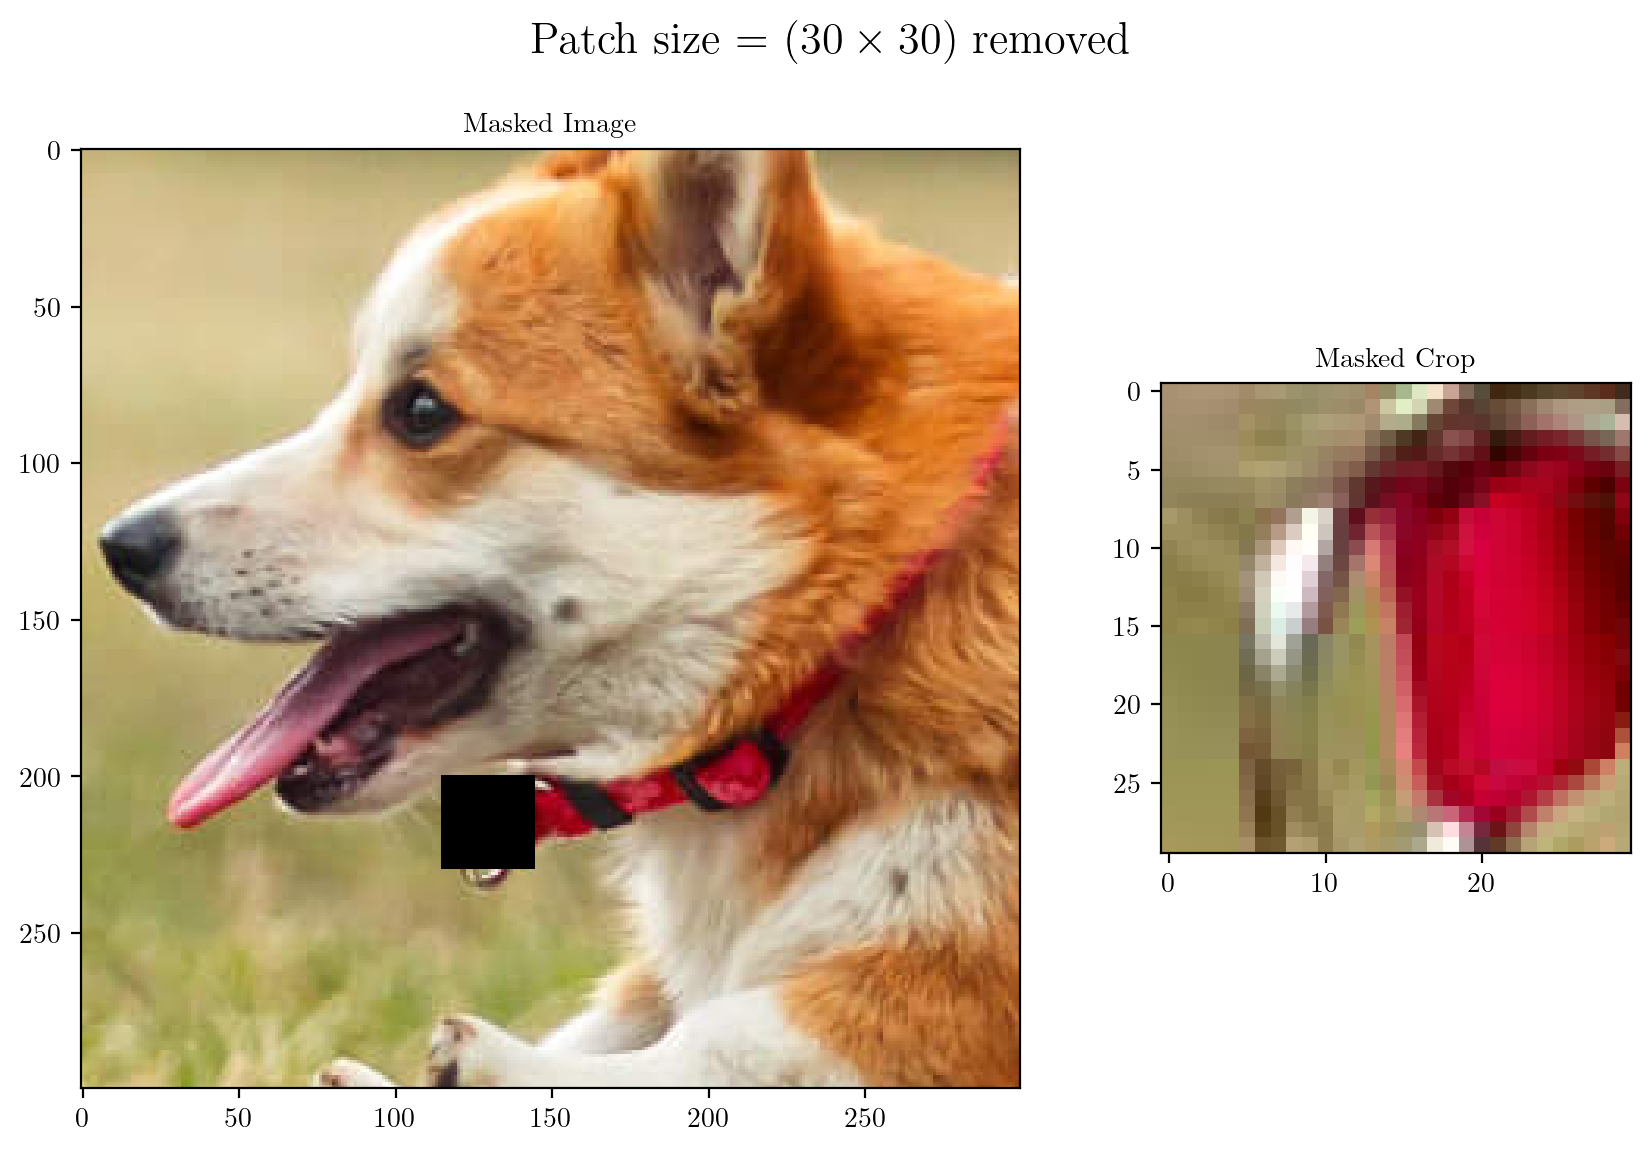

In [18]:
imgSingle30, croppedSingle30 = remove_patch(img_scaled, (200, 115), 30)

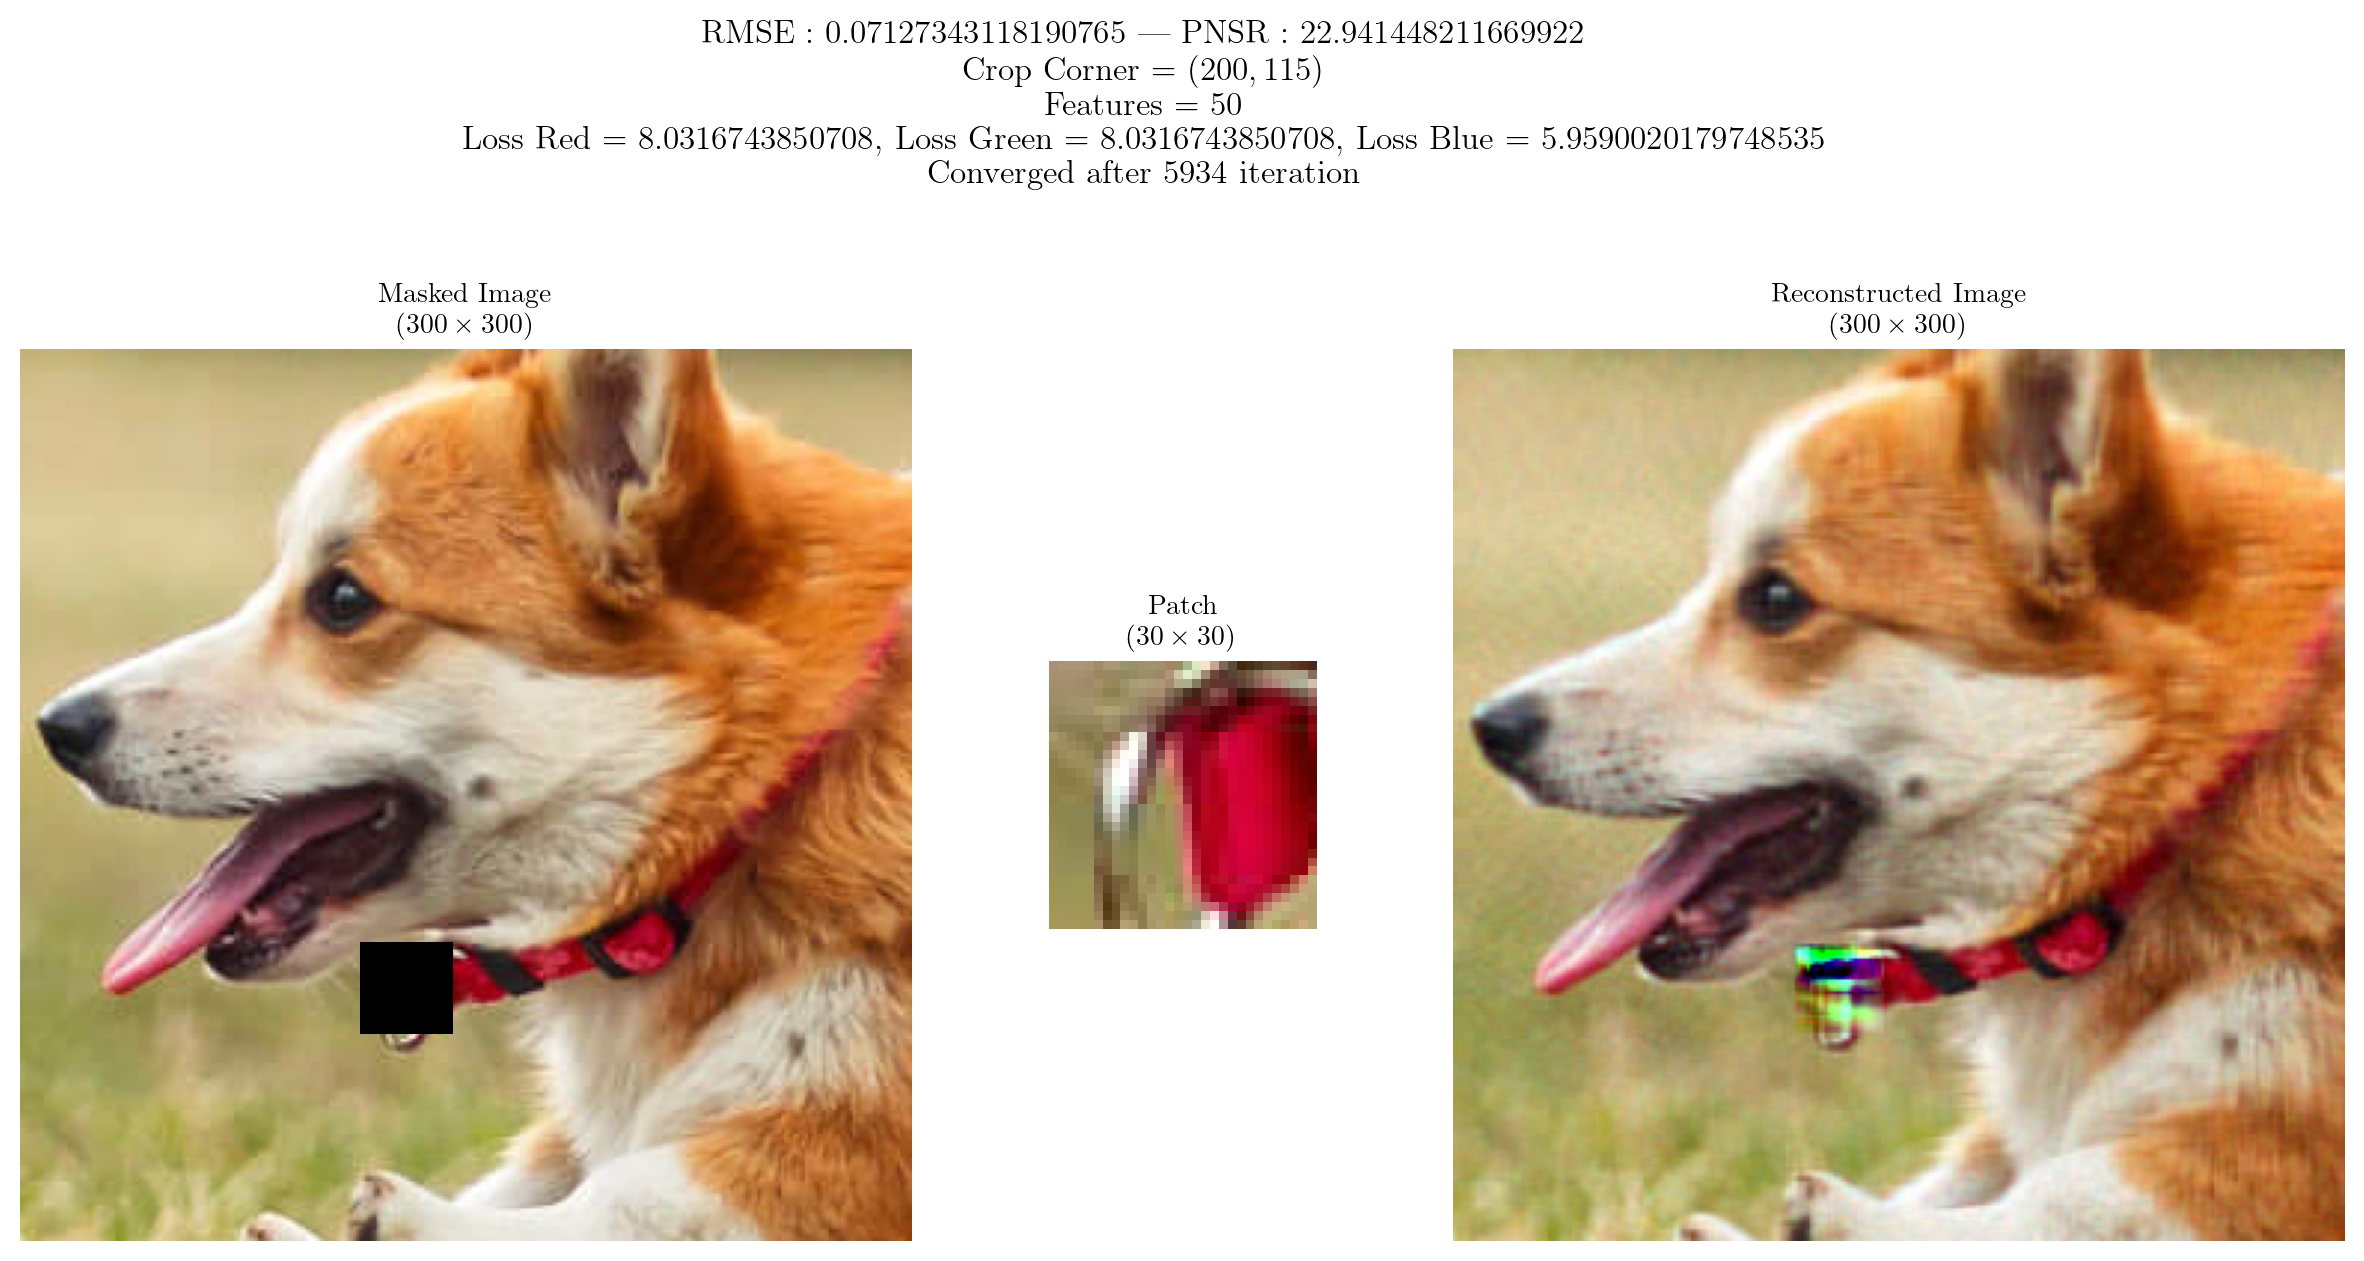

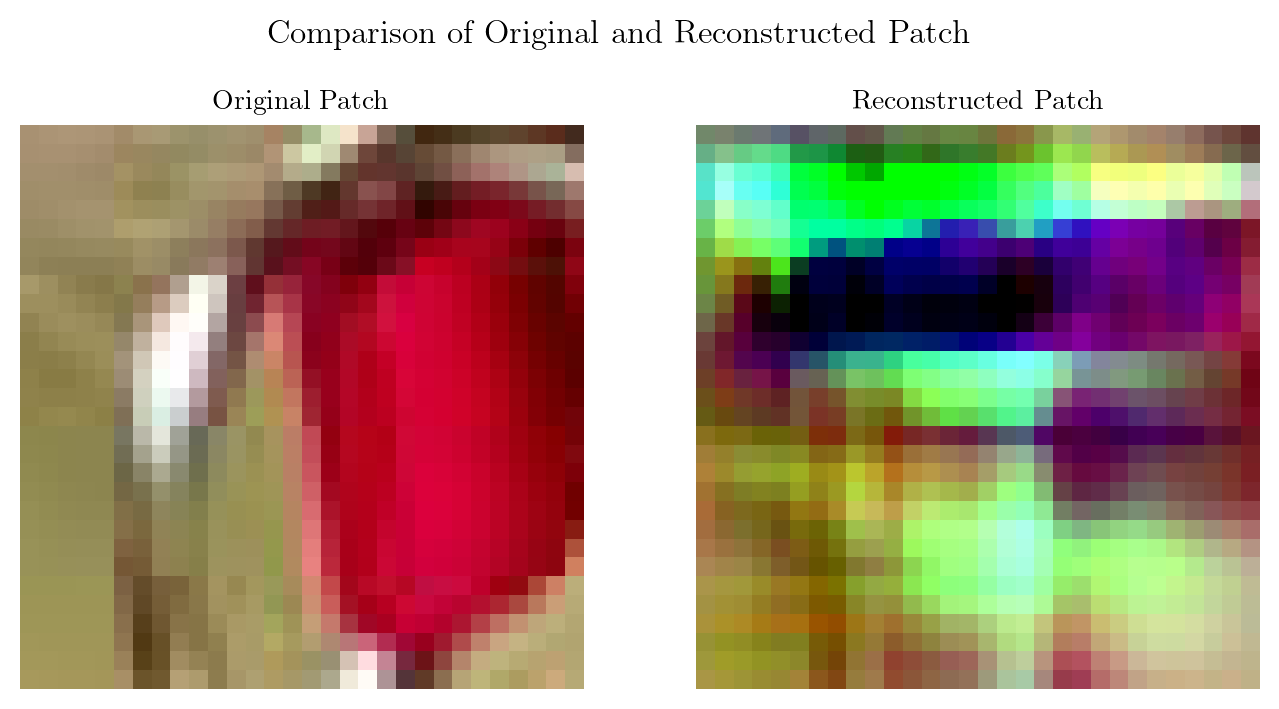

In [19]:
features = 50
train_reconstruct_plot_patch(img_scaled, (200, 115), 30, features, 1e-6, device, allowSave = True, FileName = "./Patch30x30.png")

### $900$ points $(30 \times 30)$ Points Missing

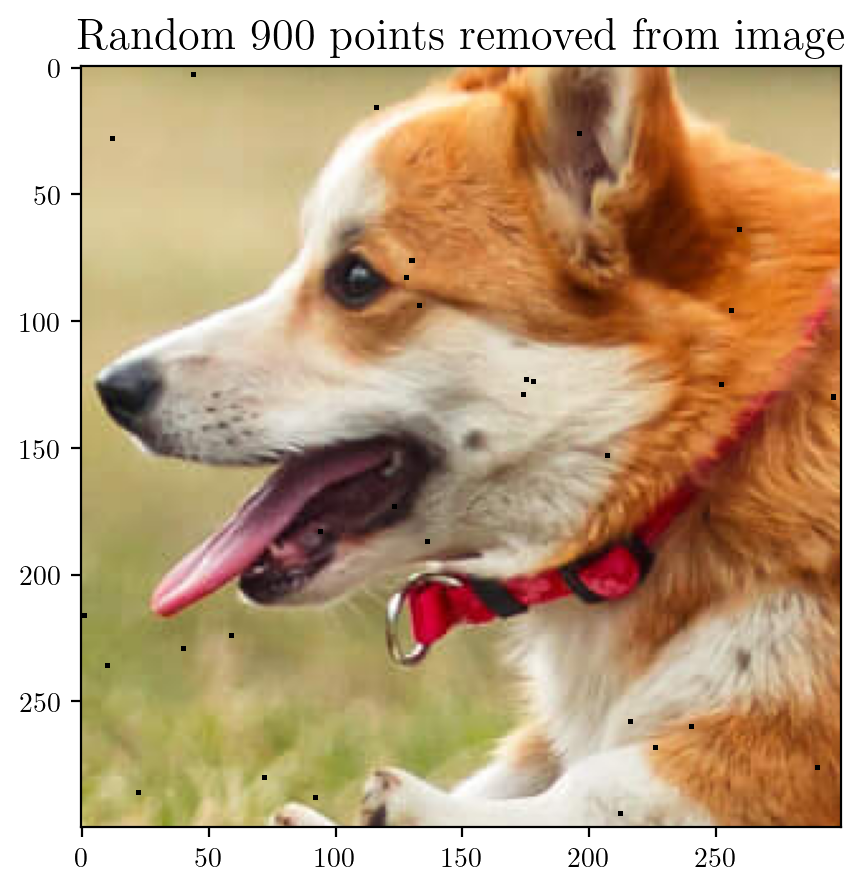

In [20]:
imgSingle900 = remove_subset(img_scaled, 30, display = True)

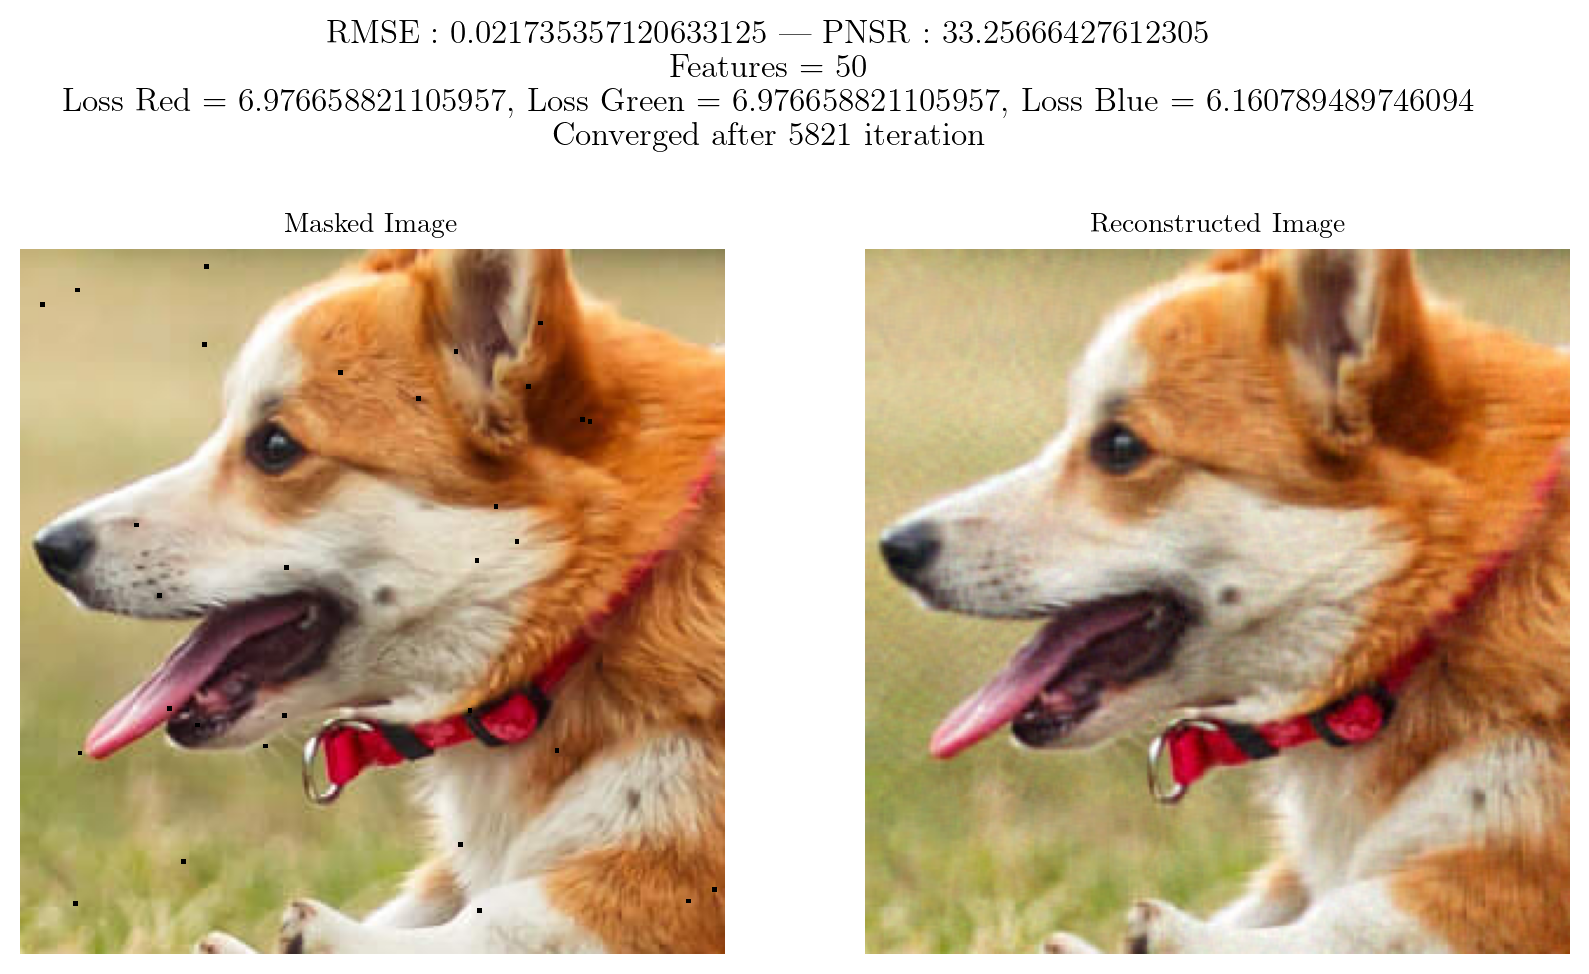

In [21]:
features = 50
train_reconstruct_plot_subset(img_scaled, 30, features, 1e-6, device, allowSave = True, FileName = "./Subset30x30.png")

## RFF

In [11]:
from sklearn.kernel_approximation import RBFSampler

$$ \text{Cordinate Map}: \mathbb{R}^2 \to \mathbb{R}^3 : [X, Y] \to [R, G, B] $$
$$ \text{Feature Map}: \mathbb{R}^{\text{features}} \to \mathbb{R}^3 : [X_{1 \cdots k}, Y_{1 \cdots k}] \to [R, G, B] $$
$$ \text{Final Map}: \mathbb{R}^2 \to \mathbb{R}^{\text{features}} \to \mathbb{R}^3 : [X, Y] \to [X_{1 \cdots k}, Y_{1 \cdots k}] \to [R, G, B] $$

$$\gamma(\mathbf{v}) = [\cos({2 \pi \mathbf{B}\mathbf{v}}), \sin({2 \pi \mathbf{B}\mathbf{v}})]^T $$
$$ \mathbf{v} \in \mathbb{R}^{\text{input}} $$
Each entry in $\mathbf{B} \in \mathbb{R}^{m \times \text{input}}$ is sampled from $\mathcal{N}(0, \sigma^2)$
$$ \gamma(\mathbf{v}) = [a_1 \cos({2 \pi \mathbf{b}_1^T\mathbf{v}}), a_1 \sin({2 \pi \mathbf{b}_1^T\mathbf{v}}), \cdots, a_m \cos({2 \pi \mathbf{b}_m^T\mathbf{v}}), a_m \sin({2 \pi \mathbf{b}_m^T\mathbf{v}})]^T $$
###  The Neural Network thus learns the approximation to $\text{Feature Map}$

In [12]:
print(img_scaled.shape)

torch.Size([3, 300, 300])


In [13]:
## RETURN TENSOR ON DEVICE

def create_coordinate_map(img):

    """
    img: torch.Tensor of shape [num_channels, height, width]

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)



    X = torch.stack([h_coords, w_coords], dim = 1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()

    return X, Y

In [14]:
dog_X, dog_Y = create_coordinate_map(img_scaled)
dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [15]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [16]:
dog_X_scaled.shape, dog_X_scaled[:10, :]

(torch.Size([90000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9933],
         [-1.0000, -0.9866],
         [-1.0000, -0.9799],
         [-1.0000, -0.9732],
         [-1.0000, -0.9666],
         [-1.0000, -0.9599],
         [-1.0000, -0.9532],
         [-1.0000, -0.9465],
         [-1.0000, -0.9398]], device='cuda:0'))

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [18]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, features)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [19]:
def predict_plot(original_img, net, X, removed_img, giveMetrics = False, allowSave = False, fileName1 = None, fileName2 = None):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))

    fig, ax = plt.subplots(nrows = 1, ncols = 3, gridspec_kw = {"width_ratios": [1, 1, 1]}, figsize = (13, 6))
    fig.suptitle(f"Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 10)
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title(fr"Ground Truth Image $({height} \times {width})$")
    ax[0].axis("off")
    ax[1].imshow(rearrange(removed_img, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title(fr"Removed Points Image")
    ax[1].axis("off")
    ax[2].imshow(outputs.cpu().detach().numpy())
    ax[2].set_title(fr"Reconstructed Image $({height} \times {width})$")
    ax[2].axis("off")

    if allowSave and fileName1 and fileName2:
      save_reconstructed_image(outputs, fileName1)
      save_reconstructed_image(rearrange(removed_img, 'c h w -> h w c'), fileName2)

    plt.show()

    if giveMetrics:
      return rmse, psnr

### Adding Random Fourier Features to Single-Layered Fully Connected Neural Network

In [20]:
def create_rff_features(X, num_features, sigma):
  rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
  X = X.cpu().numpy()
  X = rff.fit_transform(X)
  return torch.tensor(X, dtype=torch.float32).to(device)

In [28]:
torch.cuda.empty_cache()

In [29]:
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

In [30]:
X_rff.shape

torch.Size([90000, 15000])

Epoch 0 loss: 0.371087
Epoch 100 loss: 0.015645
Epoch 200 loss: 0.007995
Epoch 300 loss: 0.004615
Epoch 400 loss: 0.002859
Epoch 500 loss: 0.001910
Epoch 600 loss: 0.001378
Epoch 700 loss: 0.001068
Epoch 800 loss: 0.000879
Epoch 900 loss: 0.000760
Epoch 1000 loss: 0.000680
Epoch 1100 loss: 0.000626
Epoch 1200 loss: 0.000587
Epoch 1300 loss: 0.000558
Epoch 1400 loss: 0.000537
Epoch 1500 loss: 0.000521
Epoch 1600 loss: 0.000509
Epoch 1700 loss: 0.000499
Epoch 1800 loss: 0.000492
Epoch 1900 loss: 0.000486


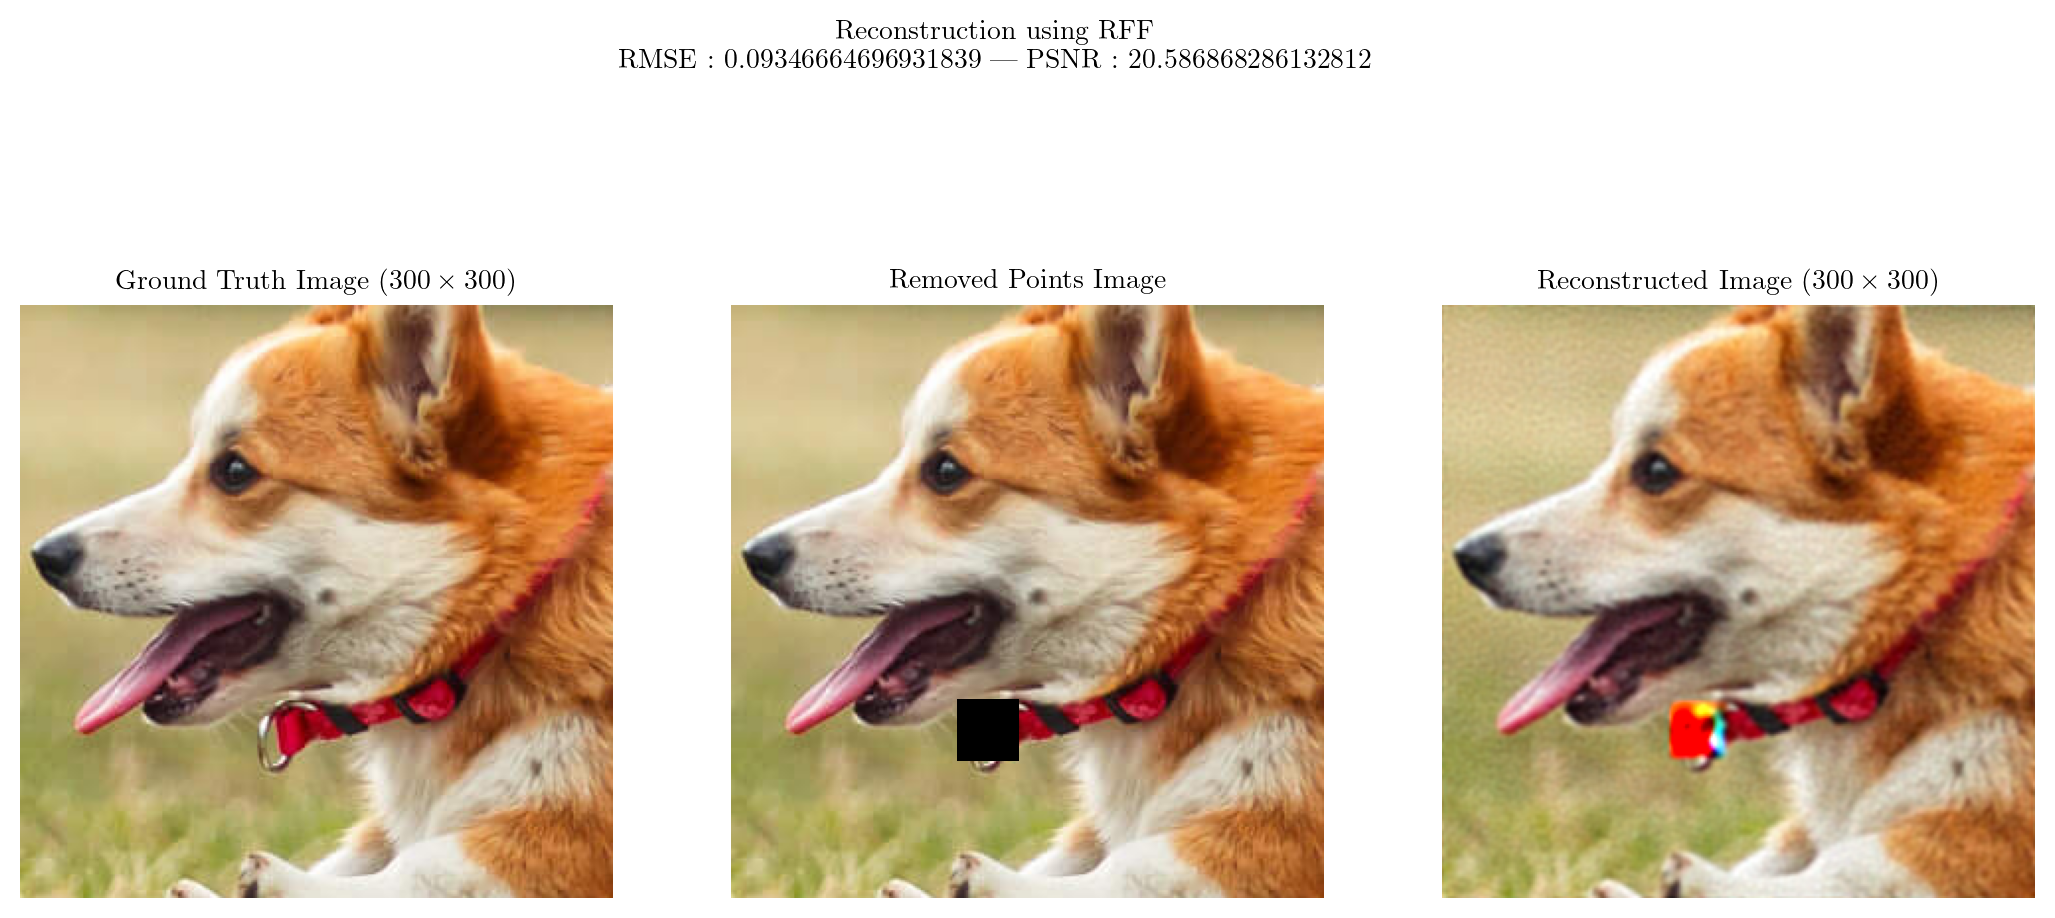

In [31]:
net = LinearModel(15000, 3)
net.to(device)
left_image, _ = remove_patch(img_scaled, (200, 115), 30, display = False)
mask = rearrange(~torch.isnan(left_image)[0], "h w -> (h w)").to(device)
train(net, 0.01, X_rff[mask], dog_Y[mask], 2000, verbose = True)
rmse, psnr = predict_plot(img_scaled, net, X_rff, left_image, giveMetrics = True, allowSave = True, fileName1 = f"./ReconstructPatch.png", fileName2 = f"./EmptyPatch.png")
del net
del mask
torch.cuda.empty_cache()

Epoch 0 loss: 0.368007
Epoch 100 loss: 0.015596
Epoch 200 loss: 0.008037
Epoch 300 loss: 0.004735
Epoch 400 loss: 0.003018
Epoch 500 loss: 0.002085
Epoch 600 loss: 0.001556
Epoch 700 loss: 0.001242
Epoch 800 loss: 0.001045
Epoch 900 loss: 0.000914
Epoch 1000 loss: 0.000824
Epoch 1100 loss: 0.000757
Epoch 1200 loss: 0.000706
Epoch 1300 loss: 0.000667
Epoch 1400 loss: 0.000635
Epoch 1500 loss: 0.000609
Epoch 1600 loss: 0.000588
Epoch 1700 loss: 0.000571
Epoch 1800 loss: 0.000557
Epoch 1900 loss: 0.000546


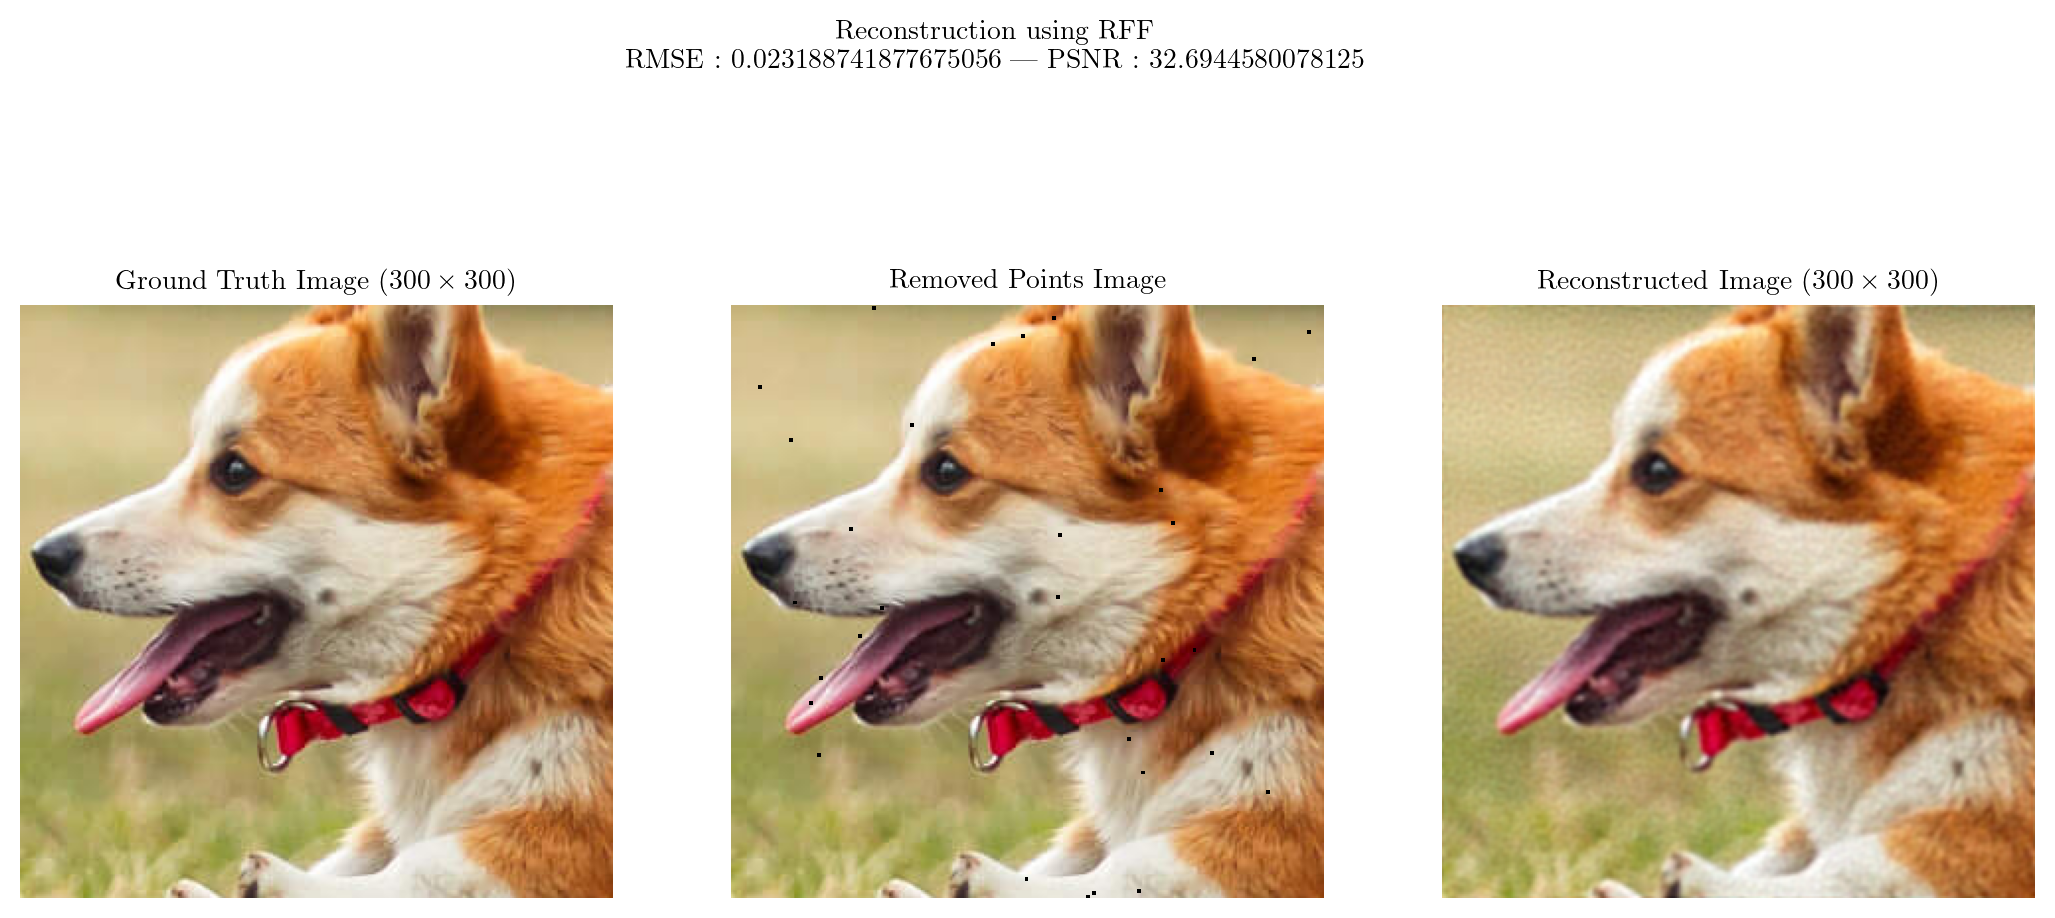

In [32]:
net = LinearModel(15000, 3)
net.to(device)
left_image = remove_subset(img_scaled, 30, display = False)
mask = rearrange(~torch.isnan(left_image)[0], "h w -> (h w)").to(device)
train(net, 0.01, X_rff[mask], dog_Y[mask], 2000, verbose = True)
rmse1, psnr1 = predict_plot(img_scaled, net, X_rff, left_image, giveMetrics = True, allowSave = True, fileName1 = f"./ReconstructSubset.png", fileName2 = f"./EmptySubset.png")
del net
del mask
torch.cuda.empty_cache()